In [1]:
import kagglehub

# # Download latest version
path = kagglehub.dataset_download("shubhammeshram579/bank-customer-churn-prediction", 
                                  path="Churn_Modelling.csv")

print("Path to dataset files:", path)

d:\shap-project\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: C:\Users\himan\.cache\kagglehub\datasets\shubhammeshram579\bank-customer-churn-prediction\versions\1\Churn_Modelling.csv


In [2]:
import pandas as pd
import numpy as np
import shap
from sklearn import set_config
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# set config

set_config(transform_output="pandas")

In [4]:
# load the data

df = pd.read_csv(path)

df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42.0,2,0.00,1,1.0,1.0,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41.0,1,83807.86,1,0.0,1.0,112542.58,0
2,3,15619304,Onio,502,France,Female,42.0,8,159660.80,3,1.0,0.0,113931.57,1
3,4,15701354,Boni,699,France,Female,39.0,1,0.00,2,0.0,0.0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43.0,2,125510.82,1,NaN,1.0,79084.10,0


In [5]:
# shape of the data

df.shape

(10002, 14)

In [6]:
# check for missing values

df.isna().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          1
Gender             0
Age                1
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          1
IsActiveMember     1
EstimatedSalary    0
Exited             0
dtype: int64

In [7]:
df.isna().any(axis=1)

0        False
1        False
2        False
3        False
4         True
         ...  
9997     False
9998     False
9999     False
10000    False
10001    False
Length: 10002, dtype: bool

In [8]:
# find the rows having missing values

(
    df.loc[
        (df.isna().any(axis=1)), :
    ]
)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
4,5,15737888,Mitchell,850,Spain,Female,43.0,2,125510.82,1,NaN,1.0,79084.10,0
6,7,15592531,Bartlett,822,NaN,Male,50.0,7,0.00,2,1.0,1.0,10062.80,0
8,9,15792365,He,501,France,Male,44.0,4,142051.07,2,0.0,NaN,74940.50,0
9,10,15592389,H?,684,France,Male,NaN,2,134603.88,1,1.0,1.0,71725.73,0


In [9]:
# drop the missing rows

df.dropna(inplace=True)

In [10]:
# missing values

df.isna().sum().sum()

np.int64(0)

In [11]:
# check for duplicates

df.duplicated().sum()

np.int64(2)

In [12]:
# duplicate rows

(
    df
    .loc[
        df.duplicated(keep=False), :
    ]
    
)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
9998,9999,15682355,Sabbatini,772,Germany,Male,42.0,3,75075.31,2,1.0,0.0,92888.52,1
9999,9999,15682355,Sabbatini,772,Germany,Male,42.0,3,75075.31,2,1.0,0.0,92888.52,1
10000,10000,15628319,Walker,792,France,Female,28.0,4,130142.79,1,1.0,0.0,38190.78,0
10001,10000,15628319,Walker,792,France,Female,28.0,4,130142.79,1,1.0,0.0,38190.78,0


In [13]:
# drop the duplicate rows

df.drop_duplicates(inplace=True)

In [14]:
# duplicates

df.duplicated().sum()

np.int64(0)

## EDA

In [15]:
df

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42.0,2,0.00,1,1.0,1.0,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41.0,1,83807.86,1,0.0,1.0,112542.58,0
2,3,15619304,Onio,502,France,Female,42.0,8,159660.80,3,1.0,0.0,113931.57,1
3,4,15701354,Boni,699,France,Female,39.0,1,0.00,2,0.0,0.0,93826.63,0
5,6,15574012,Chu,645,Spain,Male,44.0,8,113755.78,2,1.0,0.0,149756.71,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39.0,5,0.00,2,1.0,0.0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35.0,10,57369.61,1,1.0,1.0,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36.0,7,0.00,1,0.0,1.0,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42.0,3,75075.31,2,1.0,0.0,92888.52,1


In [16]:
# drop the first three columns

columns_to_drop = df.columns[0:3]

columns_to_drop

Index(['RowNumber', 'CustomerId', 'Surname'], dtype='object')

In [17]:
# drop the columns

df.drop(columns=columns_to_drop, inplace=True)

In [18]:
df

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42.0,2,0.00,1,1.0,1.0,101348.88,1
1,608,Spain,Female,41.0,1,83807.86,1,0.0,1.0,112542.58,0
2,502,France,Female,42.0,8,159660.80,3,1.0,0.0,113931.57,1
3,699,France,Female,39.0,1,0.00,2,0.0,0.0,93826.63,0
5,645,Spain,Male,44.0,8,113755.78,2,1.0,0.0,149756.71,1
...,...,...,...,...,...,...,...,...,...,...,...
9995,771,France,Male,39.0,5,0.00,2,1.0,0.0,96270.64,0
9996,516,France,Male,35.0,10,57369.61,1,1.0,1.0,101699.77,0
9997,709,France,Female,36.0,7,0.00,1,0.0,1.0,42085.58,1
9998,772,Germany,Male,42.0,3,75075.31,2,1.0,0.0,92888.52,1


In [19]:
# lowercase the column names

df.rename(columns=str.lower, inplace=True)

In [20]:
df.columns

Index(['creditscore', 'geography', 'gender', 'age', 'tenure', 'balance',
       'numofproducts', 'hascrcard', 'isactivemember', 'estimatedsalary',
       'exited'],
      dtype='object')

In [21]:
# make our X and y

X = df.drop(columns=["exited"])

y = df["exited"]

In [22]:
X

,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary
0,619,France,Female,42.0,2,0.00,1,1.0,1.0,101348.88
1,608,Spain,Female,41.0,1,83807.86,1,0.0,1.0,112542.58
2,502,France,Female,42.0,8,159660.80,3,1.0,0.0,113931.57
3,699,France,Female,39.0,1,0.00,2,0.0,0.0,93826.63
5,645,Spain,Male,44.0,8,113755.78,2,1.0,0.0,149756.71
...,...,...,...,...,...,...,...,...,...,...
9995,771,France,Male,39.0,5,0.00,2,1.0,0.0,96270.64
9996,516,France,Male,35.0,10,57369.61,1,1.0,1.0,101699.77
9997,709,France,Female,36.0,7,0.00,1,0.0,1.0,42085.58
9998,772,Germany,Male,42.0,3,75075.31,2,1.0,0.0,92888.52


In [23]:
y

0        1
1        0
2        1
3        0
5        1
        ..
9995     0
9996     0
9997     1
9998     1
10000    0
Name: exited, Length: 9996, dtype: int64

In [24]:
# datatype

df.dtypes

creditscore          int64
geography           object
gender              object
age                float64
tenure               int64
balance            float64
numofproducts        int64
hascrcard          float64
isactivemember     float64
estimatedsalary    float64
exited               int64
dtype: object

In [25]:
# list of columns

numerical_cols = ["creditscore", "age", "balance", "estimatedsalary"]

categorical_cols = ["gender", "geography"]

In [26]:
numerical_cols

['creditscore', 'age', 'balance', 'estimatedsalary']

In [27]:
remainder_cols = [column_name for column_name in X.columns if column_name not in numerical_cols + categorical_cols]

remainder_cols

['tenure', 'numofproducts', 'hascrcard', 'isactivemember']

In [28]:
df[numerical_cols]

,creditscore,age,balance,estimatedsalary
0,619,42.0,0.00,101348.88
1,608,41.0,83807.86,112542.58
2,502,42.0,159660.80,113931.57
3,699,39.0,0.00,93826.63
5,645,44.0,113755.78,149756.71
...,...,...,...,...
9995,771,39.0,0.00,96270.64
9996,516,35.0,57369.61,101699.77
9997,709,36.0,0.00,42085.58
9998,772,42.0,75075.31,92888.52


In [29]:
df[categorical_cols]

,gender,geography
0,Female,France
1,Female,Spain
2,Female,France
3,Female,France
5,Male,Spain
...,...,...
9995,Male,France
9996,Male,France
9997,Female,France
9998,Male,Germany


In [30]:
df[remainder_cols]

,tenure,numofproducts,hascrcard,isactivemember
0,2,1,1.0,1.0
1,1,1,0.0,1.0
2,8,3,1.0,0.0
3,1,2,0.0,0.0
5,8,2,1.0,0.0
...,...,...,...,...
9995,5,2,1.0,0.0
9996,10,1,1.0,1.0
9997,7,1,0.0,1.0
9998,3,2,1.0,0.0


In [31]:
from matplotlib.gridspec import GridSpec

In [32]:
def plots_for_numerical_columns(column_name, bins, kde=True):
    # set the figure size
    fig = plt.figure(figsize=(8,6))
    # gridspec
    grid = GridSpec(nrows=2, ncols=2, height_ratios=[0.6,0.4])
    
    # define the axes
    ax1 = plt.subplot(grid[0,:])
    ax2 = plt.subplot(grid[1,:])
    
    # plot the histogram
    sns.histplot(data=X, x=column_name, bins=bins, kde=kde, ax=ax1)
    
    # plot the boxplot
    sns.boxplot(data=df,x=column_name,ax=ax2)
    
    plt.show()

In [33]:
# bins for the histogram

col_bins = {
    column_name:bin_val for column_name, bin_val in zip(numerical_cols, [50,15,"auto","auto"])
}

col_bins

{'creditscore': 50, 'age': 15, 'balance': 'auto', 'estimatedsalary': 'auto'}

Creditscore



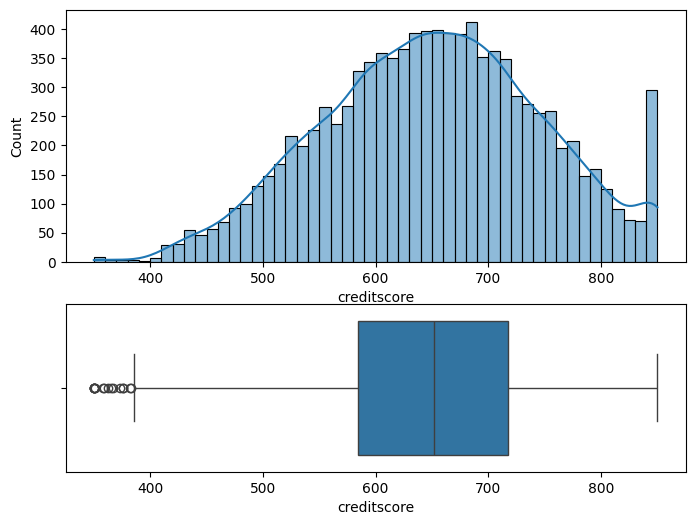




Age



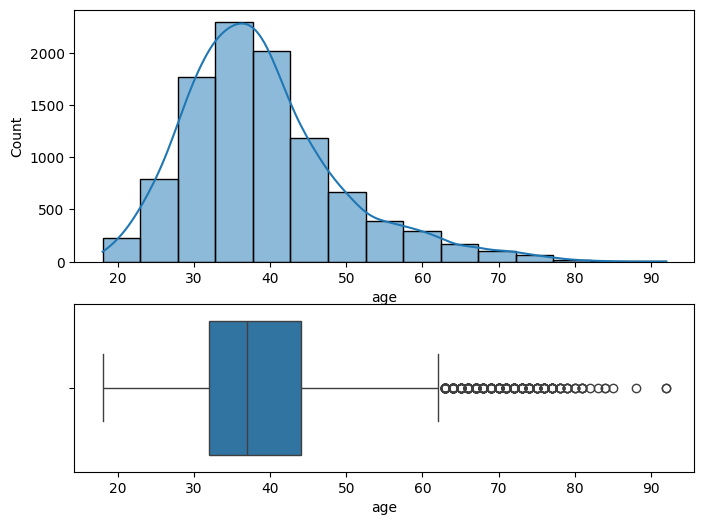




Balance



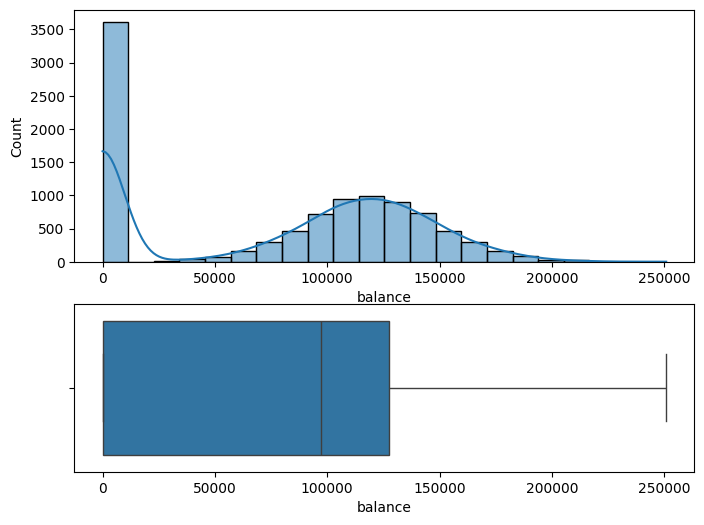




Estimatedsalary



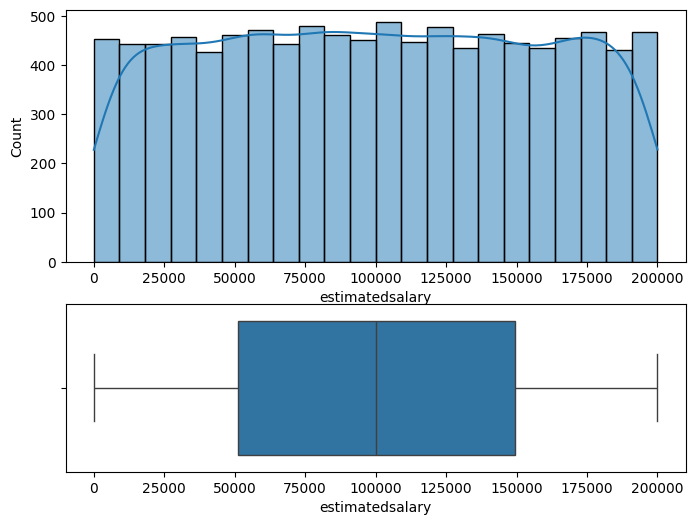

In [34]:
for num_col in numerical_cols:
    print(f"{num_col.title()}", end="\n\n")
    plots_for_numerical_columns(column_name=num_col, bins=col_bins[num_col])
    print("\n\n")

In [35]:
# people with 0 bal

(
    X.loc[
        (X["balance"].eq(0)), :
    ]
)

,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary
0,619,France,Female,42.0,2,0.0,1,1.0,1.0,101348.88
3,699,France,Female,39.0,1,0.0,2,0.0,0.0,93826.63
11,497,Spain,Male,24.0,3,0.0,2,1.0,0.0,76390.01
12,476,France,Female,34.0,10,0.0,2,1.0,0.0,26260.98
13,549,France,Female,25.0,5,0.0,2,0.0,0.0,190857.79
...,...,...,...,...,...,...,...,...,...,...
9989,841,Spain,Male,28.0,4,0.0,2,1.0,1.0,179436.60
9992,726,Spain,Male,36.0,2,0.0,1,1.0,0.0,195192.40
9994,800,France,Female,29.0,2,0.0,2,0.0,0.0,167773.55
9995,771,France,Male,39.0,5,0.0,2,1.0,0.0,96270.64


In [36]:
X["balance"].eq(0)

0         True
1        False
2        False
3         True
5        False
         ...  
9995      True
9996     False
9997      True
9998     False
10000    False
Name: balance, Length: 9996, dtype: bool

In [37]:
# new col for 0 bal customers

X["iszerobal"] = X["balance"].eq(0).astype(int)

In [38]:
X

,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,iszerobal
0,619,France,Female,42.0,2,0.00,1,1.0,1.0,101348.88,1
1,608,Spain,Female,41.0,1,83807.86,1,0.0,1.0,112542.58,0
2,502,France,Female,42.0,8,159660.80,3,1.0,0.0,113931.57,0
3,699,France,Female,39.0,1,0.00,2,0.0,0.0,93826.63,1
5,645,Spain,Male,44.0,8,113755.78,2,1.0,0.0,149756.71,0
...,...,...,...,...,...,...,...,...,...,...,...
9995,771,France,Male,39.0,5,0.00,2,1.0,0.0,96270.64,1
9996,516,France,Male,35.0,10,57369.61,1,1.0,1.0,101699.77,0
9997,709,France,Female,36.0,7,0.00,1,0.0,1.0,42085.58,1
9998,772,Germany,Male,42.0,3,75075.31,2,1.0,0.0,92888.52,0


In [39]:
def plots_for_categorical_cols(column_name):
    display(X[column_name].value_counts(normalize=True))
    print(f"There are {X[column_name].nunique()} unique values in the column {column_name} which are {X[column_name].unique()}")
    # plot the count plot
    sns.countplot(data=X,x=column_name)
    plt.show()

Gender


gender
Male      0.545618
Female    0.454382
Name: proportion, dtype: float64

There are 2 unique values in the column gender which are ['Female' 'Male']


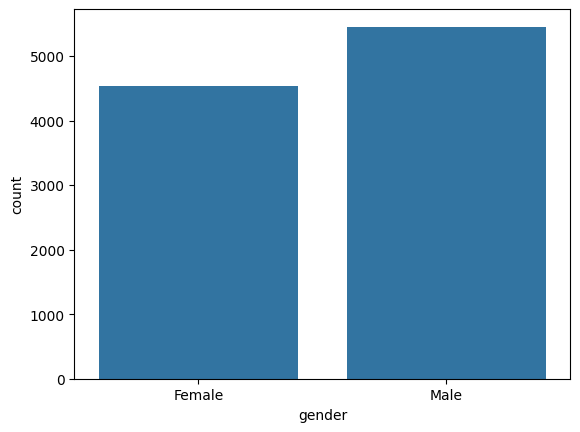




Geography


geography
France     0.501301
Germany    0.251000
Spain      0.247699
Name: proportion, dtype: float64

There are 3 unique values in the column geography which are ['France' 'Spain' 'Germany']


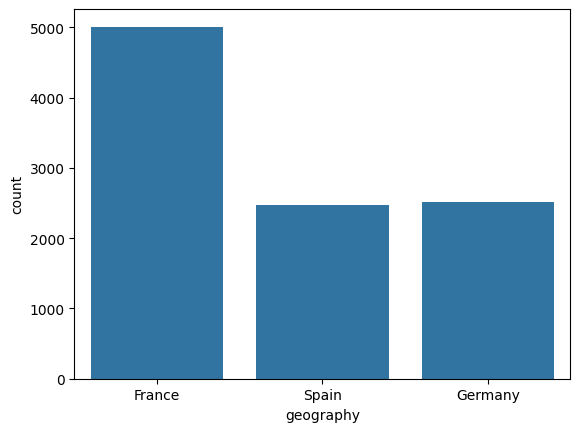

In [40]:
for cat_col in categorical_cols:
    print(f"{cat_col.title()}")
    plots_for_categorical_cols(cat_col)
    print("\n\n")

In [41]:
X

,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,iszerobal
0,619,France,Female,42.0,2,0.00,1,1.0,1.0,101348.88,1
1,608,Spain,Female,41.0,1,83807.86,1,0.0,1.0,112542.58,0
2,502,France,Female,42.0,8,159660.80,3,1.0,0.0,113931.57,0
3,699,France,Female,39.0,1,0.00,2,0.0,0.0,93826.63,1
5,645,Spain,Male,44.0,8,113755.78,2,1.0,0.0,149756.71,0
...,...,...,...,...,...,...,...,...,...,...,...
9995,771,France,Male,39.0,5,0.00,2,1.0,0.0,96270.64,1
9996,516,France,Male,35.0,10,57369.61,1,1.0,1.0,101699.77,0
9997,709,France,Female,36.0,7,0.00,1,0.0,1.0,42085.58,1
9998,772,Germany,Male,42.0,3,75075.31,2,1.0,0.0,92888.52,0


In [42]:
# distribution of target

y.value_counts(normalize=True)

exited
0    0.796218
1    0.203782
Name: proportion, dtype: float64

## FE and Model training

In [43]:
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

In [44]:
# split the data

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=30,stratify=y)

In [45]:
print(f"The shape of training data is {X_train.shape}")
print(f"The shape of test data is {X_test.shape}")

The shape of training data is (7996, 11)
The shape of test data is (2000, 11)


In [46]:
# column transformer

scaler = MinMaxScaler()

encoder = OneHotEncoder(handle_unknown="ignore",sparse_output=False)

preprocessor = ColumnTransformer(transformers=[
    ("scaler",scaler,numerical_cols),
    ("encoder",encoder,categorical_cols)
], remainder="passthrough",verbose_feature_names_out=False)

In [47]:
preprocessor

,transformers,"[('scaler', ...), ('encoder', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,False
,force_int_remainder_cols,'deprecated'
,feature_range,"(0, ...)"
,copy,True
,clip,False


In [48]:
# apply the transformation

X_train = preprocessor.fit_transform(X_train)

X_test = preprocessor.transform(X_test)

In [49]:
X_train

,creditscore,age,balance,estimatedsalary,gender_Female,gender_Male,geography_France,geography_Germany,geography_Spain,tenure,numofproducts,hascrcard,isactivemember,iszerobal
5582,0.368,0.270270,0.000000,0.719780,0.0,1.0,1.0,0.0,0.0,3,1,0.0,0.0,1
2549,0.590,0.243243,0.000000,0.060437,1.0,0.0,1.0,0.0,0.0,8,2,1.0,1.0,1
7202,0.446,0.729730,0.393649,0.480118,1.0,0.0,0.0,0.0,1.0,8,1,1.0,1.0,0
2523,0.812,0.081081,0.000000,0.921041,1.0,0.0,1.0,0.0,0.0,1,2,1.0,0.0,1
9655,0.466,0.297297,0.222307,0.134572,1.0,0.0,1.0,0.0,0.0,4,2,1.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9709,0.450,0.527027,0.549773,0.422404,1.0,0.0,1.0,0.0,0.0,8,1,1.0,1.0,0
4978,0.380,0.229730,0.509378,0.421225,0.0,1.0,0.0,1.0,0.0,7,1,0.0,1.0,0
3618,0.278,0.378378,0.366922,0.736207,1.0,0.0,0.0,1.0,0.0,8,1,1.0,0.0,0
5671,0.786,0.743243,0.000000,0.539389,1.0,0.0,1.0,0.0,0.0,6,2,0.0,1.0,1


In [50]:
X_test

,creditscore,age,balance,estimatedsalary,gender_Female,gender_Male,geography_France,geography_Germany,geography_Spain,tenure,numofproducts,hascrcard,isactivemember,iszerobal
9170,0.688,0.162162,0.000000,0.075154,0.0,1.0,1.0,0.0,0.0,2,3,0.0,1.0,1
5072,0.244,0.148649,0.408494,0.906250,0.0,1.0,1.0,0.0,0.0,8,1,0.0,1.0,0
8108,0.174,0.229730,0.505398,0.805774,0.0,1.0,0.0,1.0,0.0,6,2,1.0,1.0,0
2560,0.600,0.162162,0.000000,0.339997,1.0,0.0,0.0,0.0,1.0,6,1,0.0,0.0,1
5199,0.864,0.121622,0.000000,0.718159,1.0,0.0,0.0,0.0,1.0,3,2,1.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
618,0.392,0.324324,0.554291,0.434756,0.0,1.0,0.0,0.0,1.0,7,1,1.0,1.0,0
455,0.312,0.243243,0.000000,0.821377,0.0,1.0,1.0,0.0,0.0,5,2,1.0,0.0,1
4095,0.760,0.594595,0.447118,0.307574,0.0,1.0,0.0,0.0,1.0,5,1,0.0,1.0,0
1009,0.600,0.716216,0.000000,0.877025,0.0,1.0,0.0,0.0,1.0,0,1,1.0,1.0,1


### Model Building

In [51]:
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

In [52]:
from sklearn.ensemble import VotingClassifier

In [53]:
# define models

rf = RandomForestClassifier(class_weight="balanced", random_state=42)

xgb = XGBClassifier(class_weight="balanced", random_state=42)

lgbm = LGBMClassifier(class_weight="balanced", random_state=42)

In [54]:
# build a voting classifier

model = VotingClassifier(estimators=[
    ("rf",rf),
    ("xgb",xgb),
    ("lgbm",lgbm)
], voting="soft",n_jobs=-1)

model

,estimators,"[('rf', ...), ('xgb', ...), ...]"
,voting,'soft'
,weights,None
,n_jobs,-1
,flatten_transform,True
,verbose,False
,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1


In [55]:
# fit the model on the dataset

model.fit(X_train, y_train)

,estimators,"[('rf', ...), ('xgb', ...), ...]"
,voting,'soft'
,weights,None
,n_jobs,-1
,flatten_transform,True
,verbose,False
,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1


In [56]:
# get the predictions

y_pred = model.predict(X_test)

In [57]:
model.predict_proba(X_test.iloc[0:5,:])

array([[0.66581442, 0.33418559],
       [0.95182903, 0.04817097],
       [0.9513067 , 0.04869331],
       [0.73605231, 0.26394769],
       [0.96801903, 0.03198098]])

In [58]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.95      0.92      1592
           1       0.73      0.58      0.65       408

    accuracy                           0.87      2000
   macro avg       0.82      0.76      0.78      2000
weighted avg       0.86      0.87      0.87      2000



#### HP Tuning

In [ ]:
import optuna
from sklearn.model_selection import cross_val_score, StratifiedKFold

In [60]:
model

,estimators,"[('rf', ...), ('xgb', ...), ...]"
,voting,'soft'
,weights,None
,n_jobs,-1
,flatten_transform,True
,verbose,False
,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1


In [61]:
model.estimators

[('rf', RandomForestClassifier(class_weight='balanced', random_state=42)),
 ('xgb',
  XGBClassifier(base_score=None, booster=None, callbacks=None,
                class_weight='balanced', colsample_bylevel=None,
                colsample_bynode=None, colsample_bytree=None, device=None,
                early_stopping_rounds=None, enable_categorical=False,
                eval_metric=None, feature_types=None, feature_weights=None,
                gamma=None, grow_policy=None, importance_type=None,
                interaction_constraints=None, learning_rate=None, max_bin=None,
                max_cat_threshold=None, max_cat_to_onehot=None,
                max_delta_step=None, max_depth=None, max_leaves=None,
                min_child_weight=None, missing=nan, monotone_constraints=None,
                multi_strategy=None, n_estimators=None, n_jobs=None, ...)),
 ('lgbm', LGBMClassifier(class_weight='balanced', random_state=42))]

In [65]:
def objective(trial: optuna.Trial):
    
    params_dict = {
        "rf__n_estimators": trial.suggest_int("rf__n_estimators", 50, 200),
        "rf__max_depth": trial.suggest_int("rf__max_depth", 5, 12),
        "rf__max_samples": trial.suggest_float("rf__max_samples", 0.5, 1.0),
        "xgb__learning_rate": trial.suggest_float("xgb__learning_rate", 0.01, 0.5),
        "xgb__max_depth": trial.suggest_int("xgb__max_depth", 5, 15),
        "xgb__n_estimators": trial.suggest_int("xgb__n_estimators", 30, 200),
        "xgb__subsample": trial.suggest_float("xgb__subsample", 0.5,1.0),
        "xgb__colsample_bynode": trial.suggest_float("xgb__colsample_bynode", 0.7, 1.0),
        "xgb__reg_lambda": trial.suggest_float("xgb__reg_lambda",0.1,10.0),
        "lgbm__max_depth": trial.suggest_int("lgbm__max_depth", 5, 15),
        "lgbm__n_estimators": trial.suggest_int("lgbm__n_estimators", 30, 200),
        "lgbm__learning_rate": trial.suggest_float("lgbm__learning_rate", 0.01, 0.5),
        "lgbm__subsample": trial.suggest_float("lgbm__subsample", 0.5,1.0),
        "lgbm__reg_lambda": trial.suggest_float("lgbm__reg_lambda",0.1,10.0)
    }
    
    # define models
    rf = RandomForestClassifier(class_weight="balanced", random_state=42)
    xgb = XGBClassifier(class_weight="balanced", random_state=42)
    lgbm = LGBMClassifier(class_weight="balanced", random_state=42)
    
    # build a voting classifier
    model = VotingClassifier(estimators=[
        ("rf",rf),
        ("xgb",xgb),
        ("lgbm",lgbm)
    ], voting="soft",n_jobs=-1)
    
    # pass parameters to model
    model.set_params(**params_dict)
    
    # cross validation
    scores = cross_val_score(estimator=model,
                             X=X_train, y=y_train,
                             scoring="recall", 
                             cv=StratifiedKFold(n_splits=5,random_state=10,shuffle=True),
                             n_jobs=-1)
    
    # mean recall
    mean_recall = np.mean(scores)
    
    return mean_recall

In [ ]:
# define my study

study = optuna.create_study(direction="maximize")

study.optimize(func=objective,n_trials=100,n_jobs=-1,show_progress_bar=True)

In [67]:
# best parameters

study.best_params

{'rf__n_estimators': 70,
 'rf__max_depth': 6,
 'rf__max_samples': 0.8510112812869981,
 'xgb__learning_rate': 0.11818610361234329,
 'xgb__max_depth': 7,
 'xgb__n_estimators': 58,
 'xgb__subsample': 0.5075968020447222,
 'xgb__colsample_bynode': 0.9519132827435833,
 'xgb__reg_lambda': 4.709598362268803,
 'lgbm__max_depth': 5,
 'lgbm__n_estimators': 81,
 'lgbm__learning_rate': 0.12679175980954005,
 'lgbm__subsample': 0.8661506554773084,
 'lgbm__reg_lambda': 5.731341599571563}

In [69]:
best_params = study.best_params

In [68]:
# best score
study.best_value

0.6298216139688533

In [71]:
# define models
rf = RandomForestClassifier(class_weight="balanced", random_state=42)
xgb = XGBClassifier(class_weight="balanced", random_state=42)
lgbm = LGBMClassifier(class_weight="balanced", random_state=42)
    
# build a voting classifier
model = VotingClassifier(estimators=[
    ("rf",rf),
    ("xgb",xgb),
    ("lgbm",lgbm)
], voting="soft",n_jobs=-1)

# pass the best params to model
model.set_params(**best_params)

model

,estimators,"[('rf', ...), ('xgb', ...), ...]"
,voting,'soft'
,weights,None
,n_jobs,-1
,flatten_transform,True
,verbose,False
,n_estimators,70
,criterion,'gini'
,max_depth,6
,min_samples_split,2
,min_samples_leaf,1


In [72]:
# train the model

model.fit(X_train,y_train)

,estimators,"[('rf', ...), ('xgb', ...), ...]"
,voting,'soft'
,weights,None
,n_jobs,-1
,flatten_transform,True
,verbose,False
,n_estimators,70
,criterion,'gini'
,max_depth,6
,min_samples_split,2
,min_samples_leaf,1


In [73]:
# get the predictions
y_pred = model.predict(X_test)

In [74]:
model.predict_proba(X_test.iloc[0:3, :])

array([[0.46579869, 0.53420131],
       [0.88333579, 0.1166642 ],
       [0.85676372, 0.14323628]])

In [75]:
# classification report

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.91      0.91      0.91      1592
           1       0.64      0.65      0.64       408

    accuracy                           0.85      2000
   macro avg       0.77      0.78      0.78      2000
weighted avg       0.85      0.85      0.85      2000



## SHAP

In [76]:
# make the explainer

explainer = shap.TreeExplainer(model=model,
                               data=X_train,
                               model_output="probability")

InvalidModelError: Model type not yet supported by TreeExplainer: <class 'sklearn.ensemble._voting.VotingClassifier'>

In [77]:
model

,estimators,"[('rf', ...), ('xgb', ...), ...]"
,voting,'soft'
,weights,None
,n_jobs,-1
,flatten_transform,True
,verbose,False
,n_estimators,70
,criterion,'gini'
,max_depth,6
,min_samples_split,2
,min_samples_leaf,1


In [80]:
model.predict_proba(X_test.iloc[0:3])[:,1]

array([0.53420131, 0.1166642 , 0.14323628])

In [81]:
def prediction_fn(X):
    predictions = model.predict_proba(X)[:,1]
    return predictions

In [95]:
# model agnostic explainer

explainer = shap.Explainer(model=prediction_fn,
                           masker=X_train,
                           link=shap.links.identity)

In [84]:
X_train.shape[1]

14

In [87]:
# calculate the shap values

shap_values = explainer(X_test.iloc[[1],:])

shap_values

.values =
array([[-0.01472674, -0.14922885, -0.02933819,  0.02063866, -0.01989881,
        -0.00457314, -0.00423637, -0.02558151,  0.00108473, -0.01314821,
         0.01465945,  0.00241232, -0.02805535,  0.00213842]])

.base_values =
array([0.36451779])

.data =
array([[0.244     , 0.14864865, 0.40849362, 0.90624996, 0.        ,
        1.        , 1.        , 0.        , 0.        , 8.        ,
        1.        , 0.        , 1.        , 0.        ]])

In [88]:
shap_values.shape

(1, 14)

In [92]:
model.predict_proba(X_test.iloc[[1],:])[:,1]

array([0.1166642])

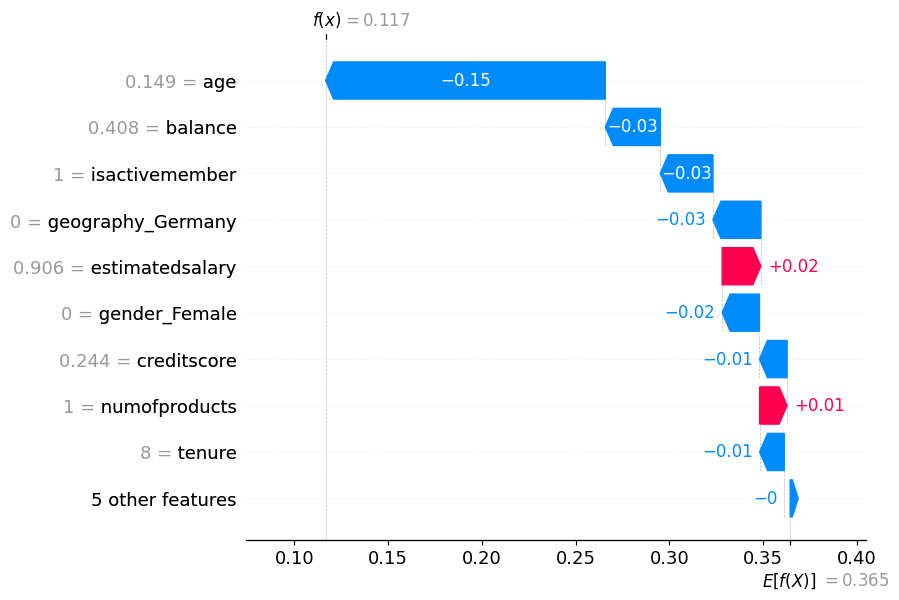

In [94]:
shap.plots.waterfall(shap_values[0])